In [21]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
# from Psemodel.psemodel import *
# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [22]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [23]:
arch = Darknet([1,2,8,8,4], 28, 32, False)
# arch = wrn_22_10()

In [24]:
arch

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [25]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [26]:
fname = train_names[0]

In [27]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 13 ms, sys: 4.25 ms, total: 17.2 ms
Wall time: 16.7 ms


In [28]:
im.shape

torch.Size([4, 512, 512])

In [29]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [30]:
from fastai.data_block import _extract_input_labels
fnames, labels = _extract_input_labels(seg, label_delim=' ')
test_fnames, _ = _extract_input_labels(sample_sub)

In [31]:
classes = uniqueify(np.concatenate(labels))

In [32]:
stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704,0.10145, 0.15313, 0.13814])
norm,denorm = normalize_funcs(*stats)

In [33]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.4, max_warp=0.4)

In [89]:
def get_data(sz=64, bs=64, is_test=False, pct = 0.1):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
    
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)



def get_data_custom(sz=64, bs=128, pct = 0.1, samples = 10000):
        folder=TRAIN
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
        train_ds, val_ds = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
        
        datasets = [train_ds,val_ds, test_ds]
        datasets = transform_datasets(*datasets, tfms=tfms, size=sz)
        sampler = ImbalancedDatasetSampler(datasets[0], num_samples=samples)
        train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
        val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
        test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)
        
        return ImageDataBunch(train_dl, val_dl, test_dl, tfms=norm)


In [35]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [36]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [37]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1], loss_func=FocalLoss(gamma=5))
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 64

In [38]:
data = get_data_custom(64, 128, 0.1)
learn = get_learner(data, focal=True, fp16=True)

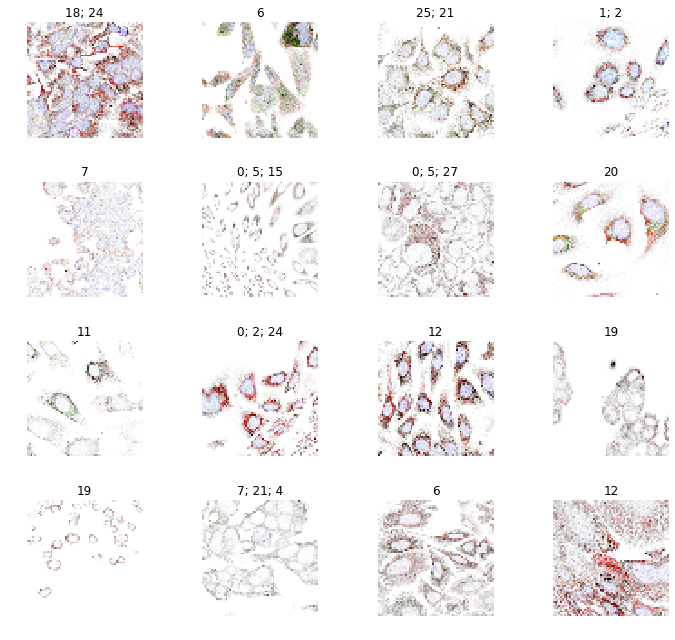

In [39]:
data.show_batch(rows=4, figsize=(10,9))

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


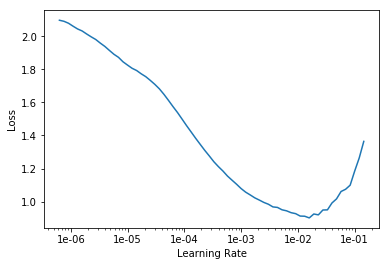

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lr=1e-3

In [42]:
%time learn.fit_one_cycle(30, lr, wd=0.3, div_factor=10, pct_start=0.5)

Total time: 44:02
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.200989    0.198031    0.944536         0.020257  (01:29)
2      0.183288    0.192202    0.946263         0.040486  (01:27)
3      0.190629    0.199222    0.942729         0.040733  (01:27)
4      0.180334    0.205041    0.942192         0.030439  (01:27)
5      0.182129    0.187853    0.947018         0.042558  (01:27)
6      0.181368    0.237866    0.934404         0.028627  (01:27)
7      0.176955    0.215318    0.940259         0.060554  (01:27)
8      0.176119    0.179579    0.946949         0.046229  (01:26)
9      0.168479    0.194235    0.942912         0.060046  (01:27)
10     0.169438    0.199753    0.942306         0.050321  (01:27)
11     0.164956    0.189942    0.943038         0.069736  (01:27)
12     0.160071    0.260096    0.934861         0.092910  (01:28)
13     0.156428    0.199907    0.942638         0.082773  (01:26)
14     0.154754    0.229573    0.938795         0.095207  (01:26)
1

# 128

In [43]:
learn.data = get_data_custom(128, 48, 0.1)

In [44]:
learn.split((arch.layers[9],arch.layers[25]))

In [45]:
learn.freeze()

In [46]:
%time learn.fit_one_cycle(10, slice(lr), wd=0.2, div_factor=10, pct_start=0.5)

Total time: 28:23
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.114786    0.133624    0.955210         0.260720  (02:50)
2      0.116280    0.144237    0.952947         0.262950  (02:49)
3      0.118551    0.139940    0.952981         0.244651  (02:49)
4      0.117740    0.166226    0.950476         0.231397  (02:50)
5      0.118138    0.149543    0.952127         0.263096  (02:50)
6      0.116355    0.136675    0.955810         0.266965  (02:50)
7      0.112735    0.137259    0.954425         0.277467  (02:50)
8      0.106588    0.128474    0.958004         0.316106  (02:50)
9      0.099832    0.127562    0.957970         0.319451  (02:50)
10     0.100671    0.125681    0.958651         0.329807  (02:50)

CPU times: user 17min 6s, sys: 10min 26s, total: 27min 33s
Wall time: 28min 23s


In [47]:
learn.unfreeze()

In [48]:
%time learn.fit_one_cycle(10, slice(lr/10, lr), wd=0.2, div_factor=10, pct_start=0.5)

Total time: 34:00
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.099909    0.132063    0.956168         0.319143  (03:23)
2      0.102964    0.135015    0.956538         0.293182  (03:24)
3      0.107480    0.147350    0.951954         0.273068  (03:23)
4      0.109045    0.150937    0.952289         0.281298  (03:23)
5      0.112650    0.167771    0.947462         0.243847  (03:23)
6      0.109941    0.137379    0.954506         0.295818  (03:25)
7      0.102914    0.141378    0.954205         0.312628  (03:24)
8      0.098228    0.125523    0.958674         0.337733  (03:23)
9      0.091510    0.120370    0.960418         0.364447  (03:23)
10     0.088510    0.119565    0.960706         0.370306  (03:24)

CPU times: user 20min 12s, sys: 12min 59s, total: 33min 11s
Wall time: 34min


In [49]:
learn.save('dk_53_128')

# 256

In [68]:
learn.data = get_data_custom(256, 40, 0.01)
# learn = get_learner(data, focal=True, fp16=True)

In [51]:
learn.freeze()

In [52]:
%time learn.fit_one_cycle(10, slice(1e-4), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 1:50:04
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.111405    0.126163    0.960181         0.249989  (10:59)
2      0.109336    0.126042    0.959770         0.260558  (10:59)
3      0.104030    0.138823    0.959052         0.264765  (11:00)
4      0.105941    0.145259    0.958847         0.267627  (11:01)
5      0.101073    0.124914    0.959873         0.266850  (11:00)
6      0.098646    0.133980    0.960591         0.276387  (11:00)
7      0.094953    0.124777    0.959360         0.269358  (11:00)
8      0.096524    0.116789    0.962952         0.286442  (11:01)
9      0.094144    0.118740    0.960694         0.279310  (11:01)
10     0.089858    0.120272    0.962130         0.278656  (11:00)

CPU times: user 1h 6min 57s, sys: 42min 50s, total: 1h 49min 48s
Wall time: 1h 50min 4s


In [69]:
learn.unfreeze()

In [70]:
%time learn.fit_one_cycle(20, slice(1e-5, 1e-4), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 4:18:55
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.083660    0.101316    0.963859         0.426592  (12:56)
2      0.083258    0.100645    0.965778         0.427554  (12:55)
3      0.081355    0.099624    0.966844         0.435374  (12:56)
4      0.080991    0.099691    0.963859         0.413128  (12:56)
5      0.081561    0.106533    0.967271         0.406727  (12:57)
6      0.082802    0.109920    0.966205         0.438941  (12:55)
7      0.082258    0.113424    0.963646         0.404035  (12:56)
8      0.079257    0.106176    0.966205         0.439617  (12:57)
9      0.078102    0.107887    0.965245         0.431487  (12:58)
10     0.076215    0.108687    0.965245         0.415198  (12:57)
11     0.078467    0.109722    0.965032         0.421641  (12:57)
12     0.076126    0.104206    0.965352         0.427597  (12:57)
13     0.075544    0.104371    0.967484         0.455773  (12:57)
14     0.073764    0.100354    0.968124         0.453898  (12:56)

In [71]:
learn.save('dk_53_256')

In [73]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# 512

In [95]:
data = get_data_custom(512, 10, 0.01)
learn = get_learner(data, focal=True, fp16=True)

In [96]:
learn.split((arch.layers[15],arch.layers[25]))

In [81]:
learn.freeze()

In [82]:
%time learn.fit_one_cycle(10, slice(1e-4), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 5:34:09
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.102339    0.139336    0.953234         0.235880  (33:25)
2      0.095010    0.138296    0.957538         0.254531  (33:26)
3      0.096561    0.150954    0.953350         0.251026  (33:25)
4      0.095266    0.152338    0.952303         0.248756  (33:24)
5      0.091831    0.145373    0.956608         0.262233  (33:24)
6      0.089658    0.133640    0.960330         0.266430  (33:22)
7      0.085278    0.138974    0.959632         0.263259  (33:21)
8      0.082853    0.132036    0.959982         0.264299  (33:24)
9      0.088064    0.150692    0.957189         0.270849  (33:26)
10     0.086221    0.137648    0.957073         0.266141  (33:27)

CPU times: user 2h 44min 49s, sys: 2h 49min 2s, total: 5h 33min 51s
Wall time: 5h 34min 9s


In [97]:
learn.unfreeze()

In [98]:
%time learn.fit_one_cycle(10, slice(1e-5, 1e-4), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 2:39:15
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.085279    0.135618    0.960381         0.270595  (15:54)
2      0.091380    0.141753    0.957051         0.265296  (15:55)
3      0.095797    0.159034    0.953836         0.246535  (15:55)
4      0.088143    0.130112    0.960037         0.262812  (15:55)
5      0.095092    0.144425    0.955788         0.255349  (15:55)
6      0.087947    0.153953    0.959462         0.249680  (15:55)
7      0.087693    0.125017    0.959922         0.273746  (15:55)
8      0.086813    0.119455    0.959577         0.272853  (15:55)
9      0.082749    0.126336    0.960956         0.281306  (15:56)
10     0.083099    0.122173    0.960611         0.276236  (15:55)

CPU times: user 1h 18min 35s, sys: 1h 20min 23s, total: 2h 38min 58s
Wall time: 2h 39min 15s


In [99]:
learn.save('dk_53_512');

# Validation and Preds

In [100]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
#valid data
learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds()

In [85]:
# np.save("preds500", to_np(p))

In [44]:
p_v.shape

torch.Size([15601, 28])

In [46]:
p_v_s = p_v.sigmoid()

In [47]:
f1(p_v, t_v)

tensor(0.8031)

In [48]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [49]:
f1_np(p_v_np, t_v_np)

0.8031076110720621

In [52]:
x = np.linspace(0,1,100)

In [53]:
y = np.array([f1_n(p_v_np, t_v_np, th, 1) for th in x])

In [54]:
import matplotlib.pyplot as plt

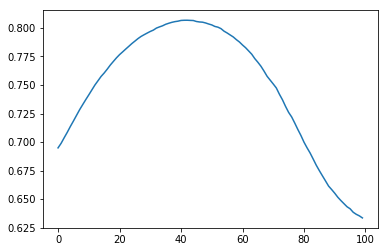

In [55]:
plt.plot(y)

In [54]:
ths = find_thresh(p_v_np, t_v_np); ths

NameError: name 'p_v_np' is not defined

In [101]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [57]:
f1_np(p_v_np, t_v_np, ths)

0.824124528146538

# Sub File

In [102]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [103]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [104]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [105]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 5 25 11 19
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25 21
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 7 5 18 25 23 19 26
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 18 25 23 6
